In [138]:
import pandas as pd

# 1. Verificamos la integridad de los datos

In [139]:
#Cargamos los datos y visualizamos los primeros

datos=pd.read_excel("E-Commerce_train.xlsx")
datos.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [140]:
# Comprobamos valores faltantes

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8999 non-null   int64 
 1   Warehouse_block      8999 non-null   object
 2   Mode_of_Shipment     8999 non-null   object
 3   Customer_care_calls  8999 non-null   int64 
 4   Customer_rating      8999 non-null   int64 
 5   Cost_of_the_Product  8999 non-null   int64 
 6   Prior_purchases      8999 non-null   int64 
 7   Product_importance   8999 non-null   object
 8   Gender               8999 non-null   object
 9   Discount_offered     8999 non-null   int64 
 10  Weight_in_gms        8999 non-null   int64 
 11  Reached.on.Time_Y.N  8999 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 843.8+ KB


Al parecer no tenemos ningún valor faltante, pero vamos a ver si es que los datos contenidos en las columnas corresponden a los que nos indican en la descripción de sus dimensiones.

In [141]:
nominales=["Warehouse_block","Mode_of_Shipment","Product_importance","Gender"]

for i in nominales:
    print(datos[i].value_counts())

F    2999
D    1500
A    1500
B    1500
C    1500
Name: Warehouse_block, dtype: int64
Ship      6122
Flight    1447
Road      1430
Name: Mode_of_Shipment, dtype: int64
low       4308
medium    3858
high       833
Name: Product_importance, dtype: int64
F    4540
M    4459
Name: Gender, dtype: int64


In [142]:
datos.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,8999.00000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000
mean,4500.00000,4.015113,2.994999,208.561507,3.511501,15.097678,3584.364596,0.635515
std,2597.93187,1.138934,1.413143,48.289172,1.532074,17.400040,1614.750194,0.481312
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2250.50000,3.000000,2.000000,168.000000,3.000000,4.000000,1857.000000,0.000000
50%,4500.00000,4.000000,3.000000,211.000000,3.000000,8.000000,4046.000000,1.000000
75%,6749.50000,5.000000,4.000000,249.500000,4.000000,19.000000,4999.500000,1.000000
max,8999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [143]:
# Buscamos datos duplicados

datos[datos.duplicated()]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


Los datos se encuentran en buen estado y según lo indicado. No se encuentra ningún valor duplicado, por lo tanto podemos seguir trabajando.

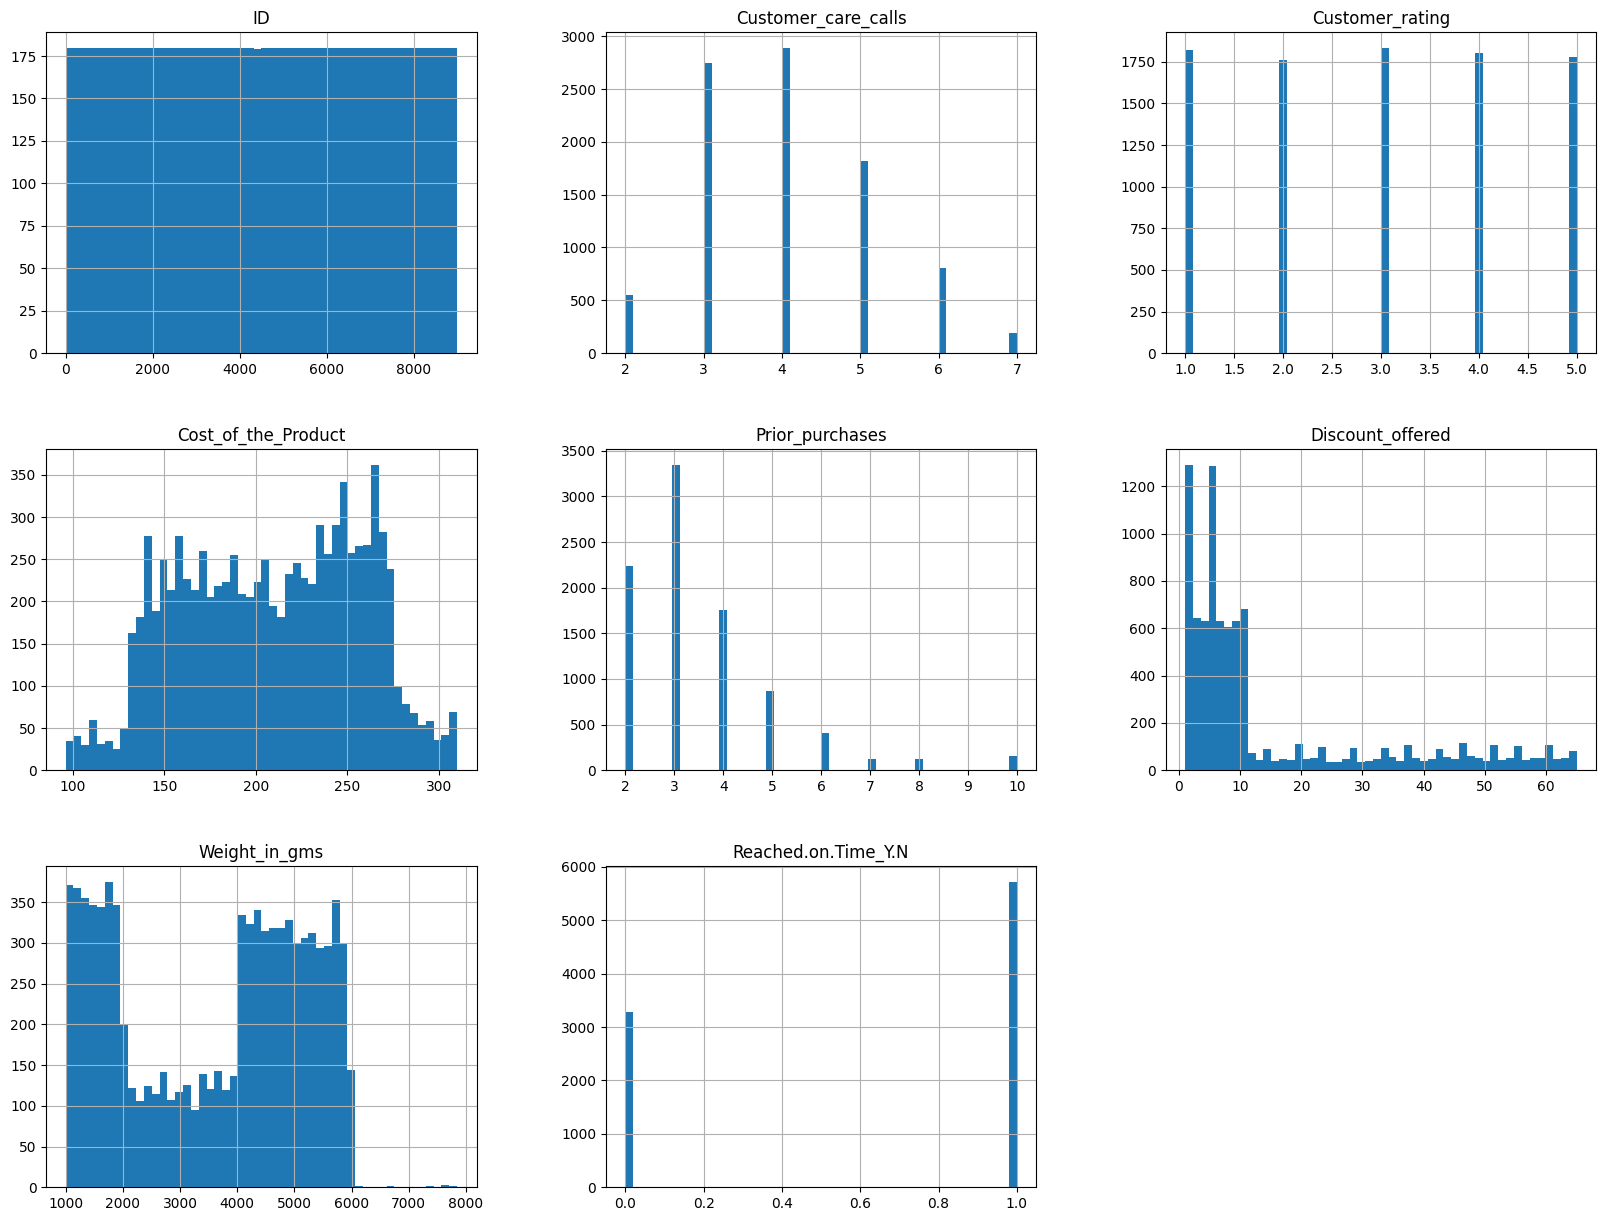

In [144]:
#hacemos un histograma de los valores numéricos

import matplotlib.pyplot as plt
datos.hist(bins=50, figsize=(20,15))
plt.show()

Es seguro que el dato de ID, no nos va a ser de utilidad para predecir si el envío llegó a tiempo o no así que podemos deshacernos de esa columna ahora mismo. 

La cantidad de estrellas de los productos tiene muy poca varianza entre si, por lo que es poco probable que nos sirva de indicadora para nuestra variable objetivo. Así que, junto con la columna de género se postulan como candidatas a ser eliminadas.

In [145]:
datos.drop(columns="ID",inplace=True)

Al parecer en Weigh in grams tenemos valores atípicos, por lo que vamos a analizar la columna en profundidad

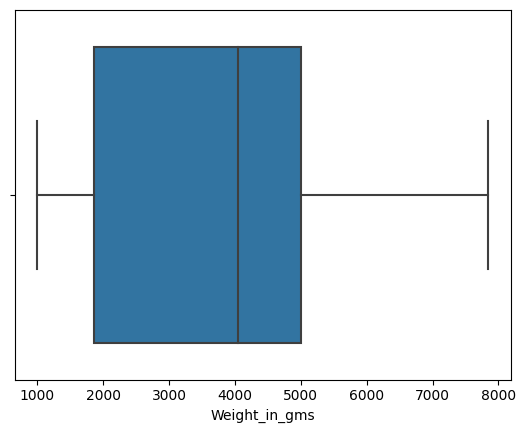

In [146]:
import seaborn as sns
sns.boxplot(x='Weight_in_gms', data=datos)
plt.show()

In [147]:
Q1 = datos['Weight_in_gms'].quantile(0.25)
Q3 = datos['Weight_in_gms'].quantile(0.75)
IQR = Q3 - Q1
BS = Q3 + 1.5*IQR

datos[datos.Weight_in_gms>BS]

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


Me falló el ojo XD No hay valores atípicos.

# Escalado normalización

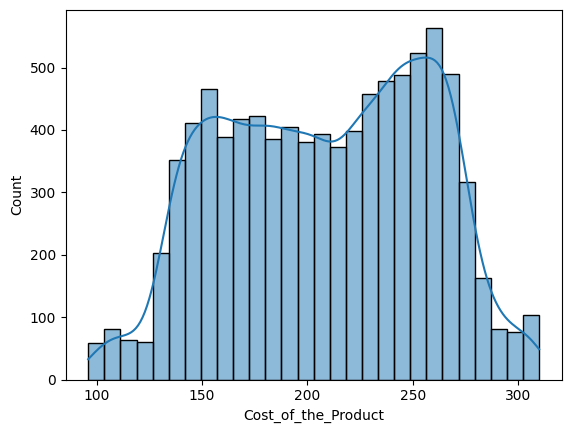

In [148]:
sns.histplot(x='Cost_of_the_Product', data=datos, kde=True)
plt.show()

In [149]:
from sklearn.preprocessing import MinMaxScaler

#instanciamos nuestro objeto con un rango de 1 a 10 ignorando la copia
scaler = MinMaxScaler(feature_range=(1,10), copy=False)

scaler.fit(datos[['Cost_of_the_Product']])

datos['Cost_of_the_Product'] = scaler.transform(datos[['Cost_of_the_Product']])

"from sklearn.preprocessing import MinMaxScaler\n\n#instanciamos nuestro objeto con un rango de 1 a 10 ignorando la copia\nscaler = MinMaxScaler(feature_range=(1,10), copy=False)\n\nscaler.fit(datos[['Cost_of_the_Product']])\n\ndatos['Cost_of_the_Product'] = scaler.transform(datos[['Cost_of_the_Product']])"

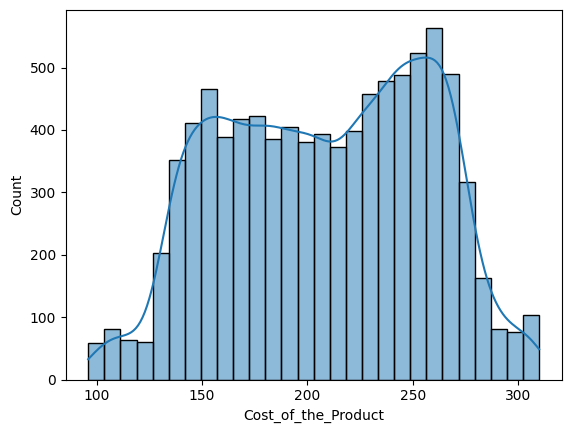

In [150]:
# Volvemos a visualizar para comprobar que no hubo cambios en la forma de la distribución

sns.histplot(x='Cost_of_the_Product', data=datos, kde=True)
plt.show()

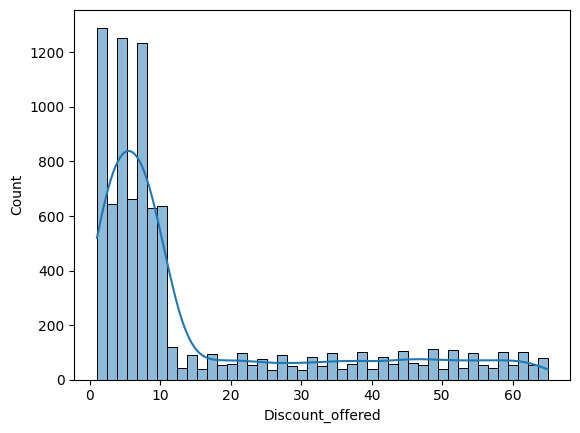

In [151]:
sns.histplot(x='Discount_offered', data=datos, kde=True)
plt.show()

In [152]:
datos['Discount_offered'].describe()

count    8999.000000
mean       15.097678
std        17.400040
min         1.000000
25%         4.000000
50%         8.000000
75%        19.000000
max        65.000000
Name: Discount_offered, dtype: float64

In [153]:
from sklearn.preprocessing import MinMaxScaler

#instanciamos nuestro objeto con un rango correspondiende al del descuento obrecido en tantos por uno, ignorando la copia
scaler = MinMaxScaler(feature_range=(.01,.65), copy=False)

scaler.fit(datos[['Discount_offered']])

datos['Discount_offered'] = scaler.transform(datos[['Discount_offered']])

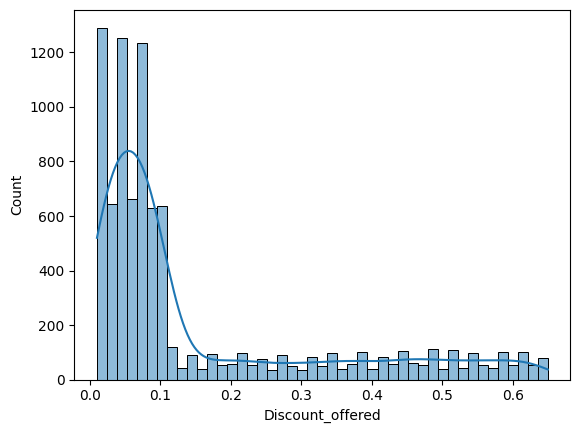

In [154]:
# Volvemos a visualizar nuestros datos
sns.histplot(x='Discount_offered', data=datos, kde=True)
plt.show()

In [155]:
datos.columns

Index(['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')

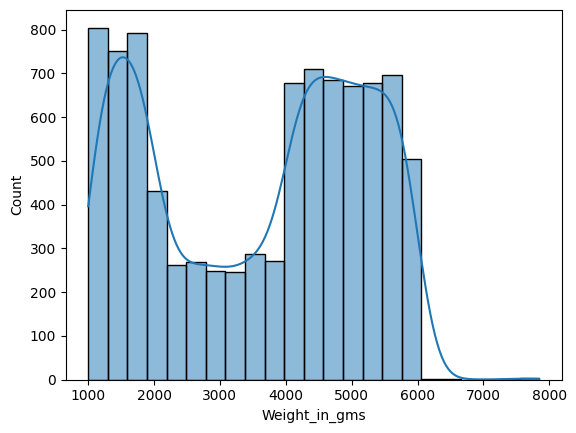

In [156]:
# Visualizamos los datos para el peso en gramos
sns.histplot(x='Weight_in_gms', data=datos, kde=True)
plt.show()

In [157]:
from sklearn.preprocessing import MinMaxScaler

#instanciamos nuestro objeto con un rango de 1 a 10 ignorando la copia
scaler = MinMaxScaler(feature_range=(1,10), copy=False)

scaler.fit(datos[['Weight_in_gms']])

datos['Weight_in_gms'] = scaler.transform(datos[['Weight_in_gms']])

# Codificación de variables nominales

In [158]:
datos[nominales].head()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


Descubrimos que lo mejor para las columnas Warehouse_block y  Mode_of_Shipment es un OneHotEscaler, Mientras que para el Product_importance y Gender lo mejor es un labelencoder.

In [159]:
# Me los transformó cualquier cosa, así que lo voy a hacer a la antigüita

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

datos['Gender'] = label_encoder.fit_transform(datos['Gender'])

In [160]:
label_encoder.classes_

array(['F', 'M'], dtype=object)

Label encoder de forma manual, para Product_importance 

In [161]:
# El procesamiento automático de label encoder les asignaba una numeración que podría hacer pensar que high tiene menos importancia que medium y low mas importancia. Por eso lo hice de forma manual

datos['Product_importance'] = datos['Product_importance'].map({"low":0,"medium":1,"high":2})

One hot encoder para Warehouse_block y Mode_of_Shipment

In [162]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Alimentamos y transformamos los datos de dos columnas
data_encoded = ohe.fit_transform(datos[["Warehouse_block","Mode_of_Shipment"]]).toarray()


In [163]:
ohe.categories_

[array(['A', 'B', 'C', 'D', 'F'], dtype=object),
 array(['Flight', 'Road', 'Ship'], dtype=object)]

In [164]:
import numpy as np

# Convertimos las categorías en un array único
etiquetas= np.concatenate(ohe.categories_, axis=0)

In [165]:
# Creamos el df a agregar al original
df_new_columns=pd.DataFrame(data_encoded,columns=etiquetas)

In [166]:
df_new_columns

,A,B,C,D,F,Flight,Road,Ship
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [167]:
datos=pd.concat([datos,df_new_columns], axis=1)

In [169]:
# Eliminamos las columnas que ya no necesitamos
datos.drop(columns=["Warehouse_block","Mode_of_Shipment"], inplace=True)

# Analizamos la correlación entre atributos

In [233]:
correlacion = datos.corr()

correlacion["Reached.on.Time_Y.N"].sort_values(ascending=False)

Reached.on.Time_Y.N    1.000000
Discount_offered       0.416357
Cost_of_the_Product    0.355209
Product_importance     0.014361
Customer_rating        0.011045
Flight                 0.009057
B                      0.006646
Ship                   0.005633
D                      0.003548
Gender                 0.002881
C                     -0.000169
F                     -0.000935
A                     -0.008842
Road                  -0.016286
Prior_purchases       -0.048269
Customer_care_calls   -0.072261
Weight_in_gms         -0.326877
Name: Reached.on.Time_Y.N, dtype: float64

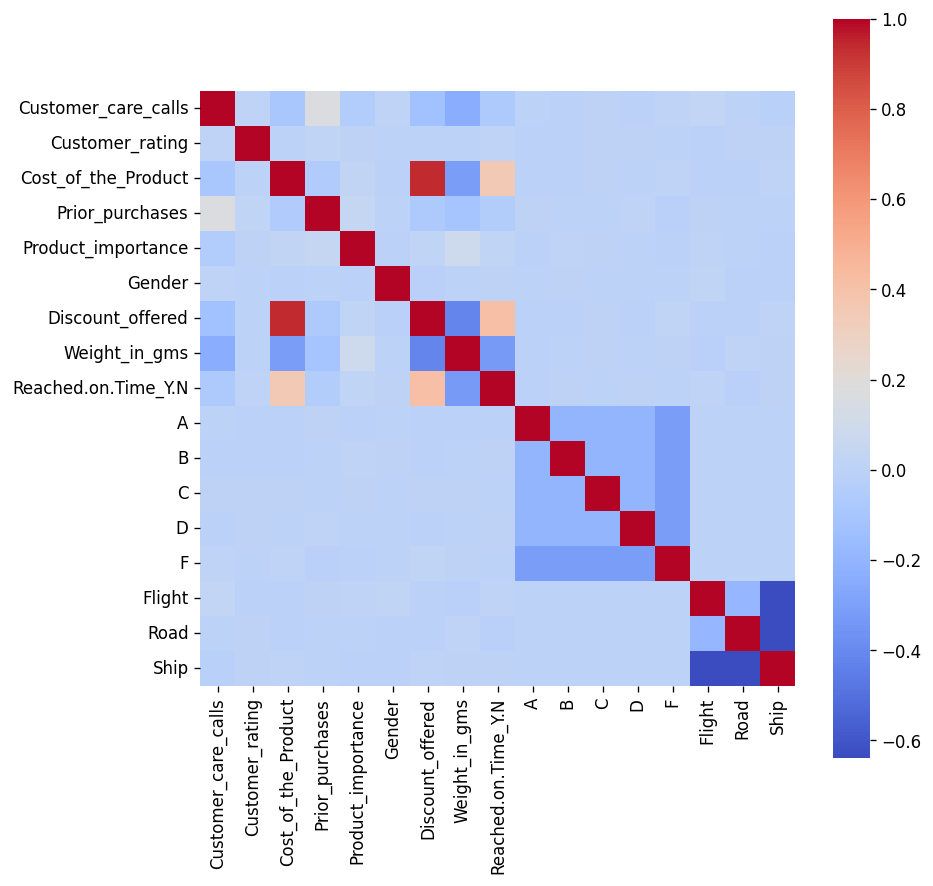

In [234]:
# greamos un lienzo de 8x8 pulgagas y una densidad de pixeles de 80
figuras, ejes = plt.subplots(figsize=(8, 8), dpi=120)

# Dejamos que infiera los valores minimos y máximos (vmin ,vmax)
sns.heatmap(correlacion, square=True, cmap="coolwarm", ax=ejes)
plt.show()

In [235]:
# sns.pairplot(datos, hue="Reached.on.Time_Y.N")

Vemos que efectivamente el Genero no es algo que infuye al momento de llegar a tiempo el pedido, pero no descartabamos la posibilidad de una empresa sexista hasta recién. Vamos a seleccionar para trabajo únicamente los datos con una correlacion superior al 0.01. Y luego utilizaremos el metodo de eliminación de características hacia atras

In [237]:
seleccion=["Discount_offered","Weight_in_gms"]

objetivo=datos["Reached.on.Time_Y.N"]

variables=datos[seleccion]

In [238]:
variables=datos[seleccion]

In [239]:
variables.shape

(8999, 2)

In [240]:
objetivo.shape

(8999,)

# Pruebas modelos ML

primero separamos nuestros datos en entrenamiento y prueba

In [241]:
from sklearn.model_selection import train_test_split

v_entreno, v_prueba, o_entreno, o_prueba = train_test_split(variables, objetivo, test_size=0.30, random_state=9)

Comenzamos empleando el algoritmo más sencillo de ML

In [242]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression()

modelo.fit(v_entreno,o_entreno)

LogisticRegression()

In [243]:
entreno_predicho = modelo.predict(v_prueba)

Creamos una funcion para medir el accuracy y el recall de cada modelo de ML que vamos a emplear, dado que esas son las metricas que queremos optimizar

In [265]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
def medidor(predicho,original):
    recal=recall_score(original, predicho.astype(int))
    acur= accuracy_score(original, predicho.astype(int))
    print("El recall es de: ", recal)
    print("el acurracy es de: ", acur)

In [245]:
medidor(entreno_predicho, o_prueba)

El recall es de:  0.7241379310344828
el acurracy es de:  0.6703703703703704


Continuamos probando un arbol de clasificación

In [246]:
from sklearn.tree import DecisionTreeRegressor

modelo_arbol = DecisionTreeRegressor()

modelo_arbol.fit(v_entreno,o_entreno)

DecisionTreeRegressor()

In [247]:
arbol_predicho=modelo_arbol.predict(v_prueba)

In [248]:
# evaluamos

medidor(arbol_predicho,o_prueba)

El recall es de:  0.746690734055355
el acurracy es de:  0.6755555555555556


Modelo SVC

In [249]:
from sklearn.svm import SVC

modeloSVC = SVC()

modeloSVC.fit(v_entreno,o_entreno)

SVC()

In [250]:
SVC_predicho=modelo_arbol.predict(v_prueba)

In [251]:
medidor(SVC_predicho,o_prueba)

El recall es de:  0.746690734055355
el acurracy es de:  0.6755555555555556


In [264]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(min_samples_split=0.08, n_estimators= 15000)

clf = clf.fit(v_entreno, o_entreno)

In [260]:
forest_predicho=modelo_arbol.predict(v_prueba)

In [266]:
medidor(forest_predicho, o_prueba)

El recall es de:  0.7317216981132075
el acurracy es de:  0.6755555555555556


Vemos que todos los modelos puntuán lo mismo, así que nos vamos a quedar con el más complejo e intentar optimizarlo

In [262]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

#scoring = { 
#            "Recall": make_scorer(recall_score), 
#            "Accuracy": make_scorer(accuracy_score)
#          }

parametros={
            'n_estimators':[10000,15000,20000],
            'min_samples_split':[.06,.07,.08]
            }

randomforest=RandomForestClassifier()

grid_search = GridSearchCV(randomforest, parametros, cv=5,
                           scoring=make_scorer(recall_score),
                           return_train_score=True,
                           refit="Recall",
                           n_jobs=-1)

grid_search.fit(v_entreno, o_entreno)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': [0.06, 0.07, 0.08],
                         'n_estimators': [10000, 15000, 20000]},
             refit='Recall', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'Recall': make_scorer(recall_score)})

In [263]:
grid_search.best_params_

{'min_samples_split': 0.08, 'n_estimators': 15000}